In [1]:
import os
import numpy as np
import cv2
import pandas as pd
import torch
from torch import nn
import torchvision
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchvision.io import decode_image
from torchvision.transforms import v2
from torchvision.transforms.functional import hflip
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import wandb
from scipy.stats import gaussian_kde as kde
import matplotlib as mpl
from torchinfo import summary
import random
import math
import time
import pickle
import sys

In [2]:
!ls /mnt/hdd/ai_n_slo/

cmi			  gazet-data-original	   gazet-depth-cropped
face_emotion_recognition  gazet_dataset_depth	   misc
gazet-data-cropped	  gazet_dataset_depth.zip  nohup.out


In [3]:
focal_length = pd.read_csv("/mnt/hdd/ai_n_slo/gazet-depth-cropped/focal_length.csv", sep="\t")
focal_length.head()

,Unnamed: 0,task_id,step,relative_x,relative_y,screen_size_x,screen_size_y,screen_size_cm_x,screen_size_cm_y,diagonal_cm,type,is_notebook,eyes_left_left,eyes_left_right,eyes_right_left,eyes_right_right,split,focallength_px
0,0,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_0.jpeg,0.0,0.0,1280,1024,33.73119,26.984952,43.197,gaze_on_fixed_point,False,"[632, 688]","[543, 698]","[434, 711]","[347, 722]",train,1596.9104
1,1,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_1.jpeg,1.0,0.0,1280,1024,33.73119,26.984952,43.197,gaze_on_fixed_point,False,"[574, 679]","[494, 684]","[395, 692]","[332, 699]",train,1642.5161
2,2,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_2.jpeg,0.0,1.0,1280,1024,33.73119,26.984952,43.197,gaze_on_fixed_point,False,"[669, 724]","[582, 733]","[475, 741]","[390, 746]",train,1613.3568
3,3,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_3.jpeg,1.0,1.0,1280,1024,33.73119,26.984952,43.197,gaze_on_fixed_point,False,"[592, 731]","[511, 739]","[416, 745]","[352, 747]",train,1640.2432
4,4,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_4.jpeg,0.5,0.5,1280,1024,33.73119,26.984952,43.197,gaze_on_fixed_point,False,"[622, 703]","[542, 711]","[444, 720]","[377, 728]",train,1643.6547


<Axes: >

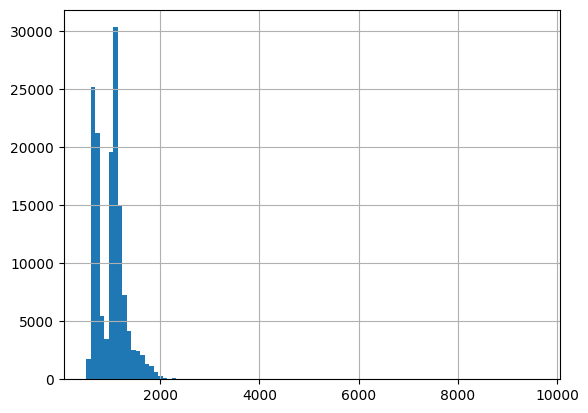

In [4]:
focal_length.focallength_px.hist(bins=100)

In [5]:
!ls /mnt/hdd/ai_n_slo/gazet-depth-cropped

depth		   eye_depth.pickle  size_errors.pickle
eof_errors.pickle  focal_length.csv


In [6]:
!ls /mnt/hdd/ai_n_slo/gazet-depth-cropped/depth/0013b518-f7b1-4e25-85f8-3f86f1d65a48

step_0.pickle	step_13.pickle	step_2.pickle  step_6.pickle
step_10.pickle	step_14.pickle	step_3.pickle  step_7.pickle
step_11.pickle	step_15.pickle	step_4.pickle  step_8.pickle
step_12.pickle	step_1.pickle	step_5.pickle  step_9.pickle


In [7]:
with open(
    "/mnt/hdd/ai_n_slo/gazet-depth-cropped/depth/0013b518-f7b1-4e25-85f8-3f86f1d65a48/step_0.pickle", 
    'rb') as file:
        # Load the data from the file using pickle.load()
        data = pickle.load(file)

data.shape

(76, 149)

In [8]:
dataset_path = "/mnt/hdd/ai_n_slo/gazet-data-cropped"
dataset_depth_path = "/mnt/hdd/ai_n_slo/gazet-depth-cropped"

In [9]:
metadata = pd.read_json(os.path.join(dataset_path, "metadata.json"))
image_sizes = pd.read_csv(os.path.join(dataset_path, "image_sizes.csv"), sep="\t", index_col=0)
print(metadata.shape)
metadata = pd.merge(metadata, image_sizes, on=["task_id", "step"])
print(metadata.shape)
metadata = pd.merge(metadata, focal_length[["task_id", "step", "focallength_px"]], on=["task_id", "step"])
print(metadata.shape)

(144275, 16)
(144275, 18)


(144208, 19)


In [10]:
metadata.head()

,task_id,step,relative_x,relative_y,screen_size_x,screen_size_y,screen_size_cm_x,screen_size_cm_y,diagonal_cm,type,is_notebook,eyes_left_left,eyes_left_right,eyes_right_left,eyes_right_right,split,h,w,focallength_px
0,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_0.jpeg,0.0,0.0,1280,1024,33.73119,26.984952,43.197,gaze_on_fixed_point,False,"[632, 688]","[543, 698]","[434, 711]","[347, 722]",train,1080,1600,1596.9104
1,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_1.jpeg,1.0,0.0,1280,1024,33.73119,26.984952,43.197,gaze_on_fixed_point,False,"[574, 679]","[494, 684]","[395, 692]","[332, 699]",train,1080,1600,1642.5161
2,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_2.jpeg,0.0,1.0,1280,1024,33.73119,26.984952,43.197,gaze_on_fixed_point,False,"[669, 724]","[582, 733]","[475, 741]","[390, 746]",train,1080,1600,1613.3568
3,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_3.jpeg,1.0,1.0,1280,1024,33.73119,26.984952,43.197,gaze_on_fixed_point,False,"[592, 731]","[511, 739]","[416, 745]","[352, 747]",train,1080,1600,1640.2432
4,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_4.jpeg,0.5,0.5,1280,1024,33.73119,26.984952,43.197,gaze_on_fixed_point,False,"[622, 703]","[542, 711]","[444, 720]","[377, 728]",train,1080,1600,1643.6547


In [11]:
metadata[metadata.split=="train"].task_id.value_counts().median(), metadata[metadata.split=="train"].task_id.value_counts().min()

(np.float64(21.0), np.int64(1))

In [12]:
metadata[metadata.split=="test"].task_id.value_counts().median(), metadata[metadata.split=="test"].task_id.value_counts().min()

(np.float64(26.0), np.int64(14))

## EDA

In [13]:
split_levels = metadata.split.unique()
type_levels = metadata.type.unique()

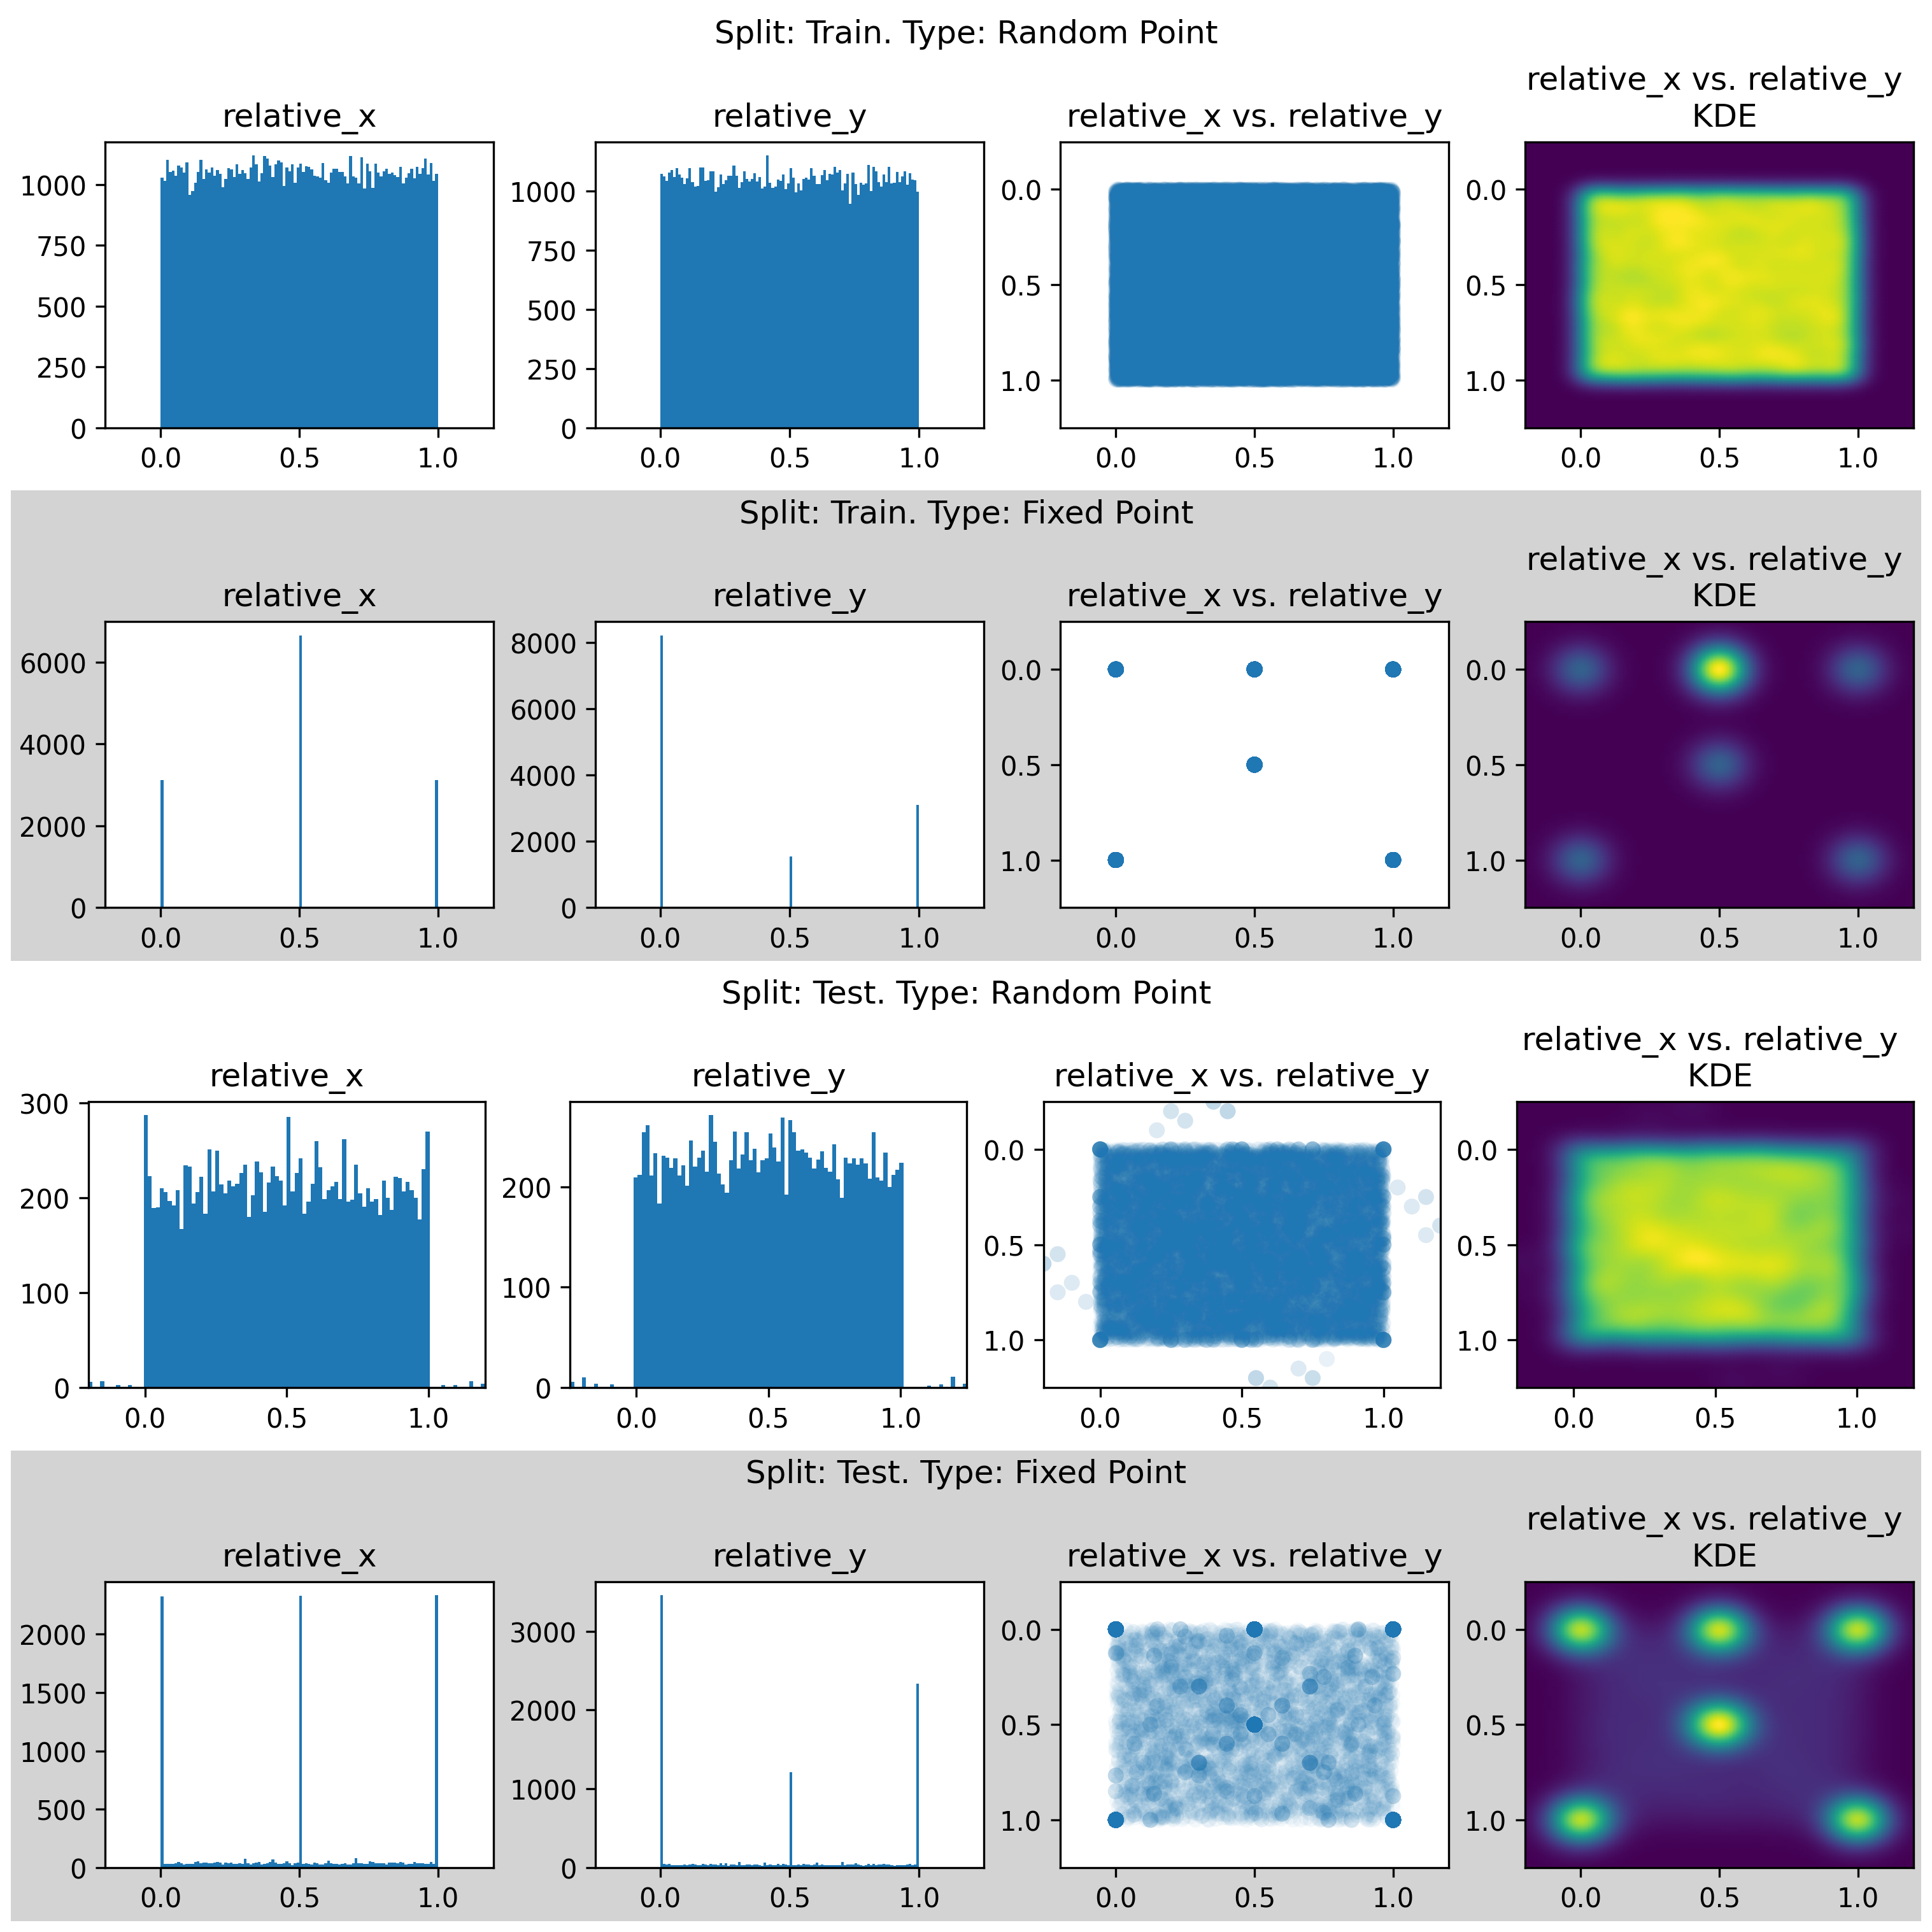

In [14]:
sf_titles = [
    "Split: Train. Type: Random Point",
    "Split: Train. Type: Fixed Point",
    "Split: Test. Type: Random Point",
    "Split: Test. Type: Fixed Point",
]

groups = [
    ("train", "gaze_on_random_point"),
    ("train", "gaze_on_fixed_point"),
    ("test", "gaze_on_random_point"),
    ("test", "gaze_on_fixed_point")
]


x_min, x_max = metadata.relative_x.min(), metadata.relative_x.max()
y_min, y_max = metadata.relative_y.min(), metadata.relative_y.max()

fig = plt.figure(layout='constrained', figsize=(10, 10), dpi=300)
subfigs = fig.subfigures(4, 1)
for sf_idx, sf in enumerate(subfigs):

    if sf_idx%2==1:
        sf.set_facecolor("lightgrey")

    split_, type_ = groups[sf_idx]
    metadata_subset = metadata[(metadata.split==split_)&(metadata.type==type_)]
    
    sf.suptitle(sf_titles[sf_idx])
    ax1, ax2, ax3, ax4 = sf.subplots(1,4)

    ax1.set_title("relative_x")
    ax1.hist(metadata_subset["relative_x"], bins=100)
    ax1.set_xlim(x_min, x_max)

    ax2.set_title("relative_y")
    ax2.hist(metadata_subset["relative_y"], bins=100)
    ax2.set_xlim(y_min, y_max)

    ax3.set_title("relative_x vs. relative_y")
    ax3.scatter(
        x=metadata_subset["relative_x"], 
        y=metadata_subset["relative_y"],
        alpha=0.05, 
        edgecolors="none"
    )
    ax3.set_xlim(x_min, x_max)
    ax3.set_ylim(y_max, y_min)

    x,y = metadata_subset[["relative_x", "relative_y"]].values.T
    
    nbins=100
    
    k = kde(np.array([x,y]))
    xi, yi = np.mgrid[x_min:x_max:nbins*1j, y_min:y_max:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    ax4.set_title("relative_x vs. relative_y \n KDE")
    ax4.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud')

    ax4.set_xlim(x_min, x_max)
    ax4.set_ylim(y_max, y_min)
    
plt.show()
# plt.savefig("./stats.png")

## Data Cleaning

In [15]:

with open (os.path.join(dataset_depth_path, "eof_errors.pickle"), "rb") as f:
    eof_errors = pickle.load(f)

print("Errors in depth data, #: ", len(eof_errors))
eof_error_task_ids = np.unique([d["task_id"] for d in eof_errors])
print("Bad task_id's, #: ", len(eof_error_task_ids))

Errors in depth data, #:  56
Bad task_id's, #:  4


In [16]:
with open (os.path.join(dataset_depth_path, "size_errors.pickle"), "rb") as f:
    size_errors = pickle.load(f)

print("Errors in depth data, #: ", len(size_errors))
size_error_task_ids = np.unique([d["task_id"] for d in size_errors])
print("Bad task_id's, #: ", len(size_error_task_ids))

Errors in depth data, #:  11
Bad task_id's, #:  7


In [17]:
# remove task_id if it has a point with relative_x or relative_y outside the [0,1] range

bad_metadata = metadata[
    (metadata.relative_x<0)|
    (metadata.relative_x>1)|
    (metadata.relative_y<0)|
    (metadata.relative_y>1)
]

print("Bad observations, #: ", len(bad_metadata))

bad_task_id = bad_metadata.task_id.unique()

print("Bad task_id's, #: ", len(bad_task_id))

print("metadata observations before cleaning ", len(metadata))
metadata = metadata[~metadata.task_id.isin(bad_task_id)]
metadata = metadata[~metadata.task_id.isin(eof_error_task_ids)]
metadata = metadata[~metadata.task_id.isin(size_error_task_ids)]
print("metadata observations after cleaning ", len(metadata))

Bad observations, #:  79
Bad task_id's, #:  25
metadata observations before cleaning  144208
metadata observations after cleaning  142756


## Create Test Sample

In [18]:
metadata_backup = metadata.copy()

In [19]:
metadata["point"] = list(zip(metadata["relative_x"], metadata["relative_y"]))
fixed_points = metadata[(metadata.split=="train")&(metadata.type=="gaze_on_fixed_point")]["point"].unique()
metadata["fixed_point"] = metadata["point"].astype("category").cat.set_categories(fixed_points)

point_counts = (
    metadata.groupby(by=["task_id", "fixed_point"], observed=False)[["step"]]
    .count().reset_index().rename(columns={"step": "point_count"})
)

In [20]:
train_task_ids = metadata[metadata.split=="train"]["task_id"].unique()
train_task_ids.shape

(5575,)

In [21]:
test_task_ids = point_counts[
point_counts.task_id.isin(metadata[metadata.split=="test"]["task_id"].unique())
].groupby("task_id")["point_count"].sum().reset_index().query("point_count==6").task_id.unique()
test_task_ids.shape

(1105,)

In [22]:
to_expand = ["eyes_left_left", "eyes_left_right", "eyes_right_left", "eyes_right_right"]
        
for col in to_expand:
    metadata[[col+"_x", col+"_y"]] = metadata[col].to_list()
    metadata[col+"_x"] = metadata[col+"_x"]/metadata["w"]
    metadata[col+"_y"] = metadata[col+"_y"]/metadata["h"]
            
metadata = metadata.drop(columns=to_expand)

In [23]:
eyes_coordinates_stats = {}
metadata_subset = metadata[metadata.split == "train"]

for col in to_expand:
    for s in ["_x", "_y"]:
        eyes_coordinates_stats[col+s] = {}
        eyes_coordinates_stats[col+s]["mean"] = metadata_subset[col+s].mean()
        eyes_coordinates_stats[col+s]["std"] = metadata_subset[col+s].std()
        
eyes_coordinates_stats  

{'eyes_left_left_x': {'mean': np.float64(0.6035024300110894),
  'std': np.float64(0.05899562022038007)},
 'eyes_left_left_y': {'mean': np.float64(0.4915194709680722),
  'std': np.float64(0.09699664312872006)},
 'eyes_left_right_x': {'mean': np.float64(0.5544904072062002),
  'std': np.float64(0.054517128605148846)},
 'eyes_left_right_y': {'mean': np.float64(0.49578197969844956),
  'std': np.float64(0.09680412579359109)},
 'eyes_right_left_x': {'mean': np.float64(0.4934139793953424),
  'std': np.float64(0.053301805300753645)},
 'eyes_right_left_y': {'mean': np.float64(0.4964748995169233),
  'std': np.float64(0.0968814262149204)},
 'eyes_right_right_x': {'mean': np.float64(0.443622584446693),
  'std': np.float64(0.056109301339831275)},
 'eyes_right_right_y': {'mean': np.float64(0.49362291734707425),
  'std': np.float64(0.09729272378466419)}}

In [24]:
relative_x_mean = metadata[metadata.split == "train"]["relative_x"].mean()
relative_x_std = metadata[metadata.split == "train"]["relative_x"].std()
relative_y_mean = metadata[metadata.split == "train"]["relative_y"].mean()
relative_y_std = metadata[metadata.split == "train"]["relative_y"].std()

relative_x_mean, relative_x_std, relative_y_mean, relative_y_std

(np.float64(0.5000233729866089),
 np.float64(0.29527566271216554),
 np.float64(0.4773593501788009),
 np.float64(0.3128780618497263))

In [25]:
focallength_mean = metadata.loc[metadata.split == "train", "focallength_px"].mean()
focallength_std = metadata.loc[metadata.split == "train", "focallength_px"].std()
focallength_mean, focallength_std

(np.float64(1008.0179512914052), np.float64(317.59046993003534))

In [26]:
h_mean = metadata.loc[metadata.split == "train", "h"].mean()
h_std = metadata.loc[metadata.split == "train", "h"].std()
w_mean = metadata.loc[metadata.split == "train", "w"].mean()
w_std = metadata.loc[metadata.split == "train", "w"].std()
h_mean, h_std, w_mean, w_std

(np.float64(675.6249533819291),
 np.float64(187.18950162138796),
 np.float64(1071.0216646889303),
 np.float64(368.2672692976219))

In [27]:
next(metadata.iterrows())

(0,
 task_id               8f0ba296-96d9-4ff0-8de9-13cc0e2ae671
 step                                           step_0.jpeg
 relative_x                                             0.0
 relative_y                                             0.0
 screen_size_x                                         1280
 screen_size_y                                         1024
 screen_size_cm_x                                  33.73119
 screen_size_cm_y                                 26.984952
 diagonal_cm                                         43.197
 type                                   gaze_on_fixed_point
 is_notebook                                          False
 split                                                train
 h                                                     1080
 w                                                     1600
 focallength_px                                   1596.9104
 point                                           (0.0, 0.0)
 fixed_point                        

In [28]:
resnet_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

depth_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=False),
    v2.Normalize(mean=[-0.64285594], std=[0.2275102])
])

def get_img(task_id, step, data_dir=dataset_path):
    img_path = os.path.join(
        data_dir, "images/",
        task_id, step
    )
    
    image = decode_image(img_path)
    image = resnet_transforms(image)

    # h = image.shape[1]
    # w = image.shape[2]

    # image_ratio = 2 #width/height
    # resize_height = 224
    # resize_width = resize_height*image_ratio

    # if w/h <= image_ratio:
    #     padding = h*image_ratio - w
    #     padding_left = round(padding/2)
    #     padding_right = padding - padding_left
    #     image = v2.Pad(padding=[padding_left,0,padding_right,0])(image)
    #     image = v2.Resize(size=resize_height, interpolation = transforms.InterpolationMode.NEAREST)(image)
    # else:
    #     image = v2.Resize(size = None, max_size=resize_width, interpolation = transforms.InterpolationMode.NEAREST)(image)
    #     padding = resize_height - image.shape[1]
    #     padding_top = round(padding/2)
    #     padding_bottom = padding - padding_top
    #     image = v2.Pad(padding=[0,padding_top,0,padding_bottom])(image)

    return image


def get_depth(task_id, step, data_dir=dataset_depth_path):
    depth_path = os.path.join(
            dataset_depth_path, "depth/",
            task_id, step[:-4]+"pickle"
        )
    
    with open(depth_path, "rb") as f:
        depth = pickle.load(f)


    depth = np.clip(depth, 0, 1)
    depth = (depth - 0.537918)/0.12179518

    # depth = np.log(depth)
    # depth = (depth + 0.64285594)/0.2275102
    
    depth = torch.from_numpy(np.array([depth])).to(torch.float32)
    
    # depth = depth_transforms(depth)

    return depth

In [29]:
# DEPTH = []
# for row_idx, row in metadata[metadata.split=="train"].reset_index(drop=True).iterrows():
#     task_id = row.task_id    
#     step = row.step
#     D = get_depth(task_id, step)
#     DEPTH.append(D.ravel())

#     if row_idx>0 and row_idx%10_000 == 0:
#         print(f"[{row_idx}/{len(metadata[metadata.split=='train'])}]")

In [30]:
# len(DEPTH)

In [31]:
# DEPTH_CONCATENATED = np.concatenate(DEPTH)

In [32]:
# len(DEPTH_CONCATENATED), np.mean(DEPTH_CONCATENATED), np.std(DEPTH_CONCATENATED)

In [33]:
# np.std(np.log(DEPTH_CONCATENATED))

In [34]:
# np.mean(np.log(DEPTH_CONCATENATED))

In [35]:
# np.min(DEPTH_CONCATENATED)

In [36]:
# plt.hist(DEPTH_CONCATENATED, bins=100)
# plt.show()

In [37]:
# np.quantile(DEPTH_CONCATENATED, 0.99), np.quantile(DEPTH_CONCATENATED, 0.999)

In [38]:
# DEPTH_CONCATENATED_CLIPPED = np.clip(DEPTH_CONCATENATED, 0, 1)

In [39]:
# plt.hist(DEPTH_CONCATENATED_CLIPPED, bins=100)
# plt.show()

In [40]:
# np.mean(DEPTH_CONCATENATED_CLIPPED), np.std(DEPTH_CONCATENATED_CLIPPED)

In [41]:
# plt.hist(np.sqrt(DEPTH_CONCATENATED), bins=100)

In [42]:
# plt.hist(np.log(DEPTH_CONCATENATED), bins=100)

In [43]:
image_container = {}
depth_container = {}

for row_idx, row in metadata.reset_index(drop=True).iterrows():
    task_id = row.task_id
    step = row.step

    image_container[(task_id, step)] = get_img(task_id, step)
    depth_container[(task_id, step)] = get_depth(task_id, step)

    if row_idx>0 and row_idx%10_000 == 0:
        print(f"[{row_idx}/{len(metadata)}]")


[10000/142756]


[20000/142756]


[30000/142756]


[40000/142756]


[50000/142756]


[60000/142756]


[70000/142756]


[80000/142756]


[90000/142756]


[100000/142756]


[110000/142756]


[120000/142756]


[130000/142756]


[140000/142756]


In [44]:
depth_keys = list(depth_container.keys())

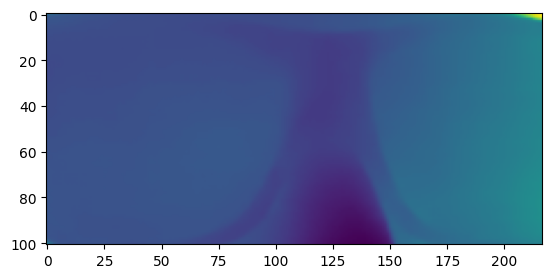

In [45]:
plt.imshow(depth_container[depth_keys[5_200]].squeeze(0).numpy())

(array([4.226e+03, 6.498e+03, 1.787e+03, 7.650e+02, 2.210e+02, 1.400e+01,
        3.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-0.61787456, -0.50413793, -0.39040127, -0.27666461, -0.16292799,
        -0.04919136,  0.06454533,  0.17828196,  0.29201859,  0.40575522,
         0.51949185,  0.63322848,  0.74696523,  0.86070186,  0.97443849,
         1.08817506,  1.20191169,  1.31564832,  1.42938495,  1.54312158,
         1.65685821,  1.77059484,  1.88433146,  1.99806809,  2.11180496,
         2.22554159,  2.33927822,  2.45301485,  2.56675148,  2.68048811,
         2.79422474]),
 <BarContainer object of 30 artists>)

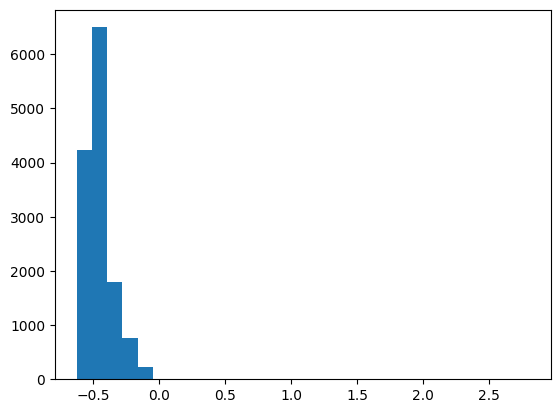

In [46]:
plt.hist(depth_container[depth_keys[6_300]].squeeze(0).numpy().ravel(), bins=30)

In [47]:
image_container[depth_keys[1_560]].std()

tensor(1.0691)

In [48]:
image_stds_1 = []
image_stds_2 = []
image_stds_3 = []

for k in depth_keys:
    image_stds_1.append(image_container[k][0].std().item())
    image_stds_2.append(image_container[k][1].std().item())
    image_stds_3.append(image_container[k][2].std().item())

In [49]:
np.mean(image_stds_3)

np.float64(0.5620203739862156)

(array([3.100e+01, 2.800e+01, 1.300e+01, 5.100e+01, 9.100e+01, 8.700e+01,
        2.190e+02, 5.050e+02, 7.830e+02, 1.062e+03, 1.093e+03, 1.072e+03,
        1.238e+03, 1.507e+03, 1.700e+03, 2.385e+03, 2.458e+03, 2.454e+03,
        2.596e+03, 2.621e+03, 3.063e+03, 3.277e+03, 3.699e+03, 3.522e+03,
        3.648e+03, 3.820e+03, 3.723e+03, 4.288e+03, 4.397e+03, 4.268e+03,
        4.306e+03, 4.241e+03, 4.050e+03, 3.755e+03, 3.721e+03, 3.693e+03,
        3.566e+03, 3.423e+03, 3.141e+03, 2.995e+03, 2.636e+03, 2.854e+03,
        2.622e+03, 2.495e+03, 2.418e+03, 2.238e+03, 1.961e+03, 2.059e+03,
        1.902e+03, 1.593e+03, 1.536e+03, 1.553e+03, 1.479e+03, 1.304e+03,
        1.190e+03, 1.280e+03, 1.057e+03, 1.008e+03, 1.105e+03, 8.760e+02,
        9.900e+02, 1.079e+03, 7.660e+02, 7.360e+02, 6.700e+02, 6.130e+02,
        4.880e+02, 4.700e+02, 4.460e+02, 4.810e+02, 4.180e+02, 3.760e+02,
        4.060e+02, 3.760e+02, 3.170e+02, 3.110e+02, 3.060e+02, 2.290e+02,
        2.190e+02, 1.720e+02, 1.130e+0

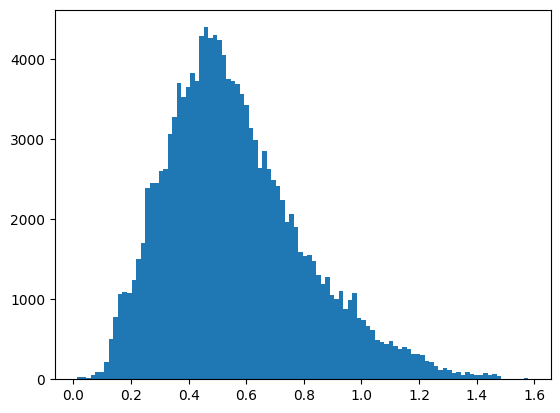

In [50]:
plt.hist(image_stds_2, bins=100)

In [51]:
stds = []

for k in depth_keys:
    stds.append(depth_container[k].std().item())

(array([1.5510e+03, 1.0470e+03, 1.9307e+04, 5.3696e+04, 3.8591e+04,
        1.3132e+04, 4.3900e+03, 2.0390e+03, 1.2080e+03, 9.5100e+02,
        7.2300e+02, 6.1200e+02, 5.7700e+02, 4.0800e+02, 3.5400e+02,
        3.6100e+02, 3.3000e+02, 3.0500e+02, 3.0100e+02, 2.2800e+02,
        2.3400e+02, 2.0200e+02, 2.2100e+02, 1.7400e+02, 1.5100e+02,
        1.7200e+02, 1.3500e+02, 1.0300e+02, 1.1700e+02, 1.0700e+02,
        1.0100e+02, 9.1000e+01, 8.8000e+01, 6.6000e+01, 8.0000e+01,
        7.0000e+01, 5.2000e+01, 5.2000e+01, 5.3000e+01, 4.0000e+01,
        3.9000e+01, 2.1000e+01, 2.3000e+01, 2.1000e+01, 1.9000e+01,
        2.9000e+01, 1.9000e+01, 1.6000e+01, 2.5000e+01, 9.0000e+00,
        2.1000e+01, 1.6000e+01, 9.0000e+00, 8.0000e+00, 8.0000e+00,
        7.0000e+00, 9.0000e+00, 9.0000e+00, 3.0000e+00, 9.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.00

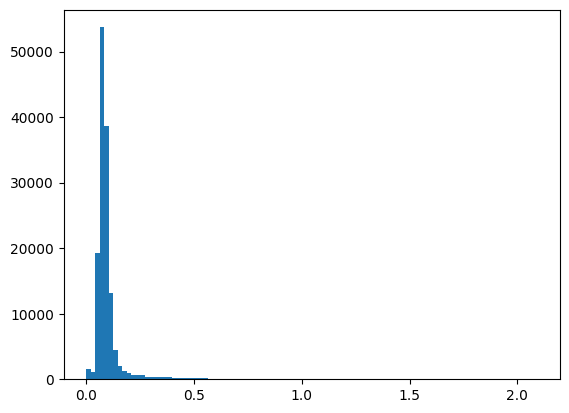

In [52]:
plt.hist(stds, bins=100)

In [53]:
np.mean(stds)

np.float64(0.10036114072071292)

In [54]:

train_data_main = []
train_data_calibration = {}
test_data_main = []
test_data_calibration = {}

for container, ids_list in [(train_data_calibration, train_task_ids), (test_data_calibration, test_task_ids)]:
    for task_id in ids_list:
        container[task_id] = []

fixed_points_set = set(fixed_points)
train_task_ids_set = set(train_task_ids)
test_task_ids_set = set(test_task_ids)

n_points = 6

dist_value = 0.2

def distance(d1,d2):
        return ((d1["metadata"].relative_x - d2["metadata"].relative_x)**2 + (d1["metadata"].relative_y - d2["metadata"].relative_y)**2)**0.5

def encloser(datum, task_id, step, container, train):

    def lambda_train():
        calibration_steps = [s for s in container[task_id] if distance(datum, s) > dist_value]
        return random.choices(calibration_steps, k=n_points)

    # def lambda_test():
    #     calibration_steps = [s for s in container[task_id] if s["metadata"].step != step]
    #     output = []

    #     while len(output) < n_points:
    #         output += calibration_steps
            
    #     return output[:n_points]
        
    if train:
        return lambda_train
    else:
        return lambda: container[task_id]

for row_idx, row in metadata.iterrows():
    task_id = row.task_id
    step = row.step
    point = row.point
    datum = {"metadata": row, "img": (task_id, step)}
    if task_id in train_task_ids_set:
        datum["get_calibration"] = encloser(datum, task_id, step, train_data_calibration, train=True)
        train_data_calibration[task_id].append(datum)
        train_data_main.append(datum)
    elif task_id in test_task_ids_set:
        datum["get_calibration"] = encloser(datum, task_id, step, test_data_calibration, train=False)
        if point in fixed_points_set:
            test_data_calibration[task_id].append(datum)
        else:
            test_data_main.append(datum)

    if row_idx>0 and row_idx%10_000 == 0:
        print(f"[{row_idx}/{len(metadata)}]")

to_remove = []
for d1 in train_data_main:
    count = 0
    for d2 in train_data_calibration[d1["metadata"].task_id]:
        if distance(d1,d2) > dist_value:
            count+=1
    if count <= 3:
        to_remove.append(d1)

to_remove_ids = [d["metadata"].task_id for d in to_remove]
print(len(train_data_main))
train_data_main = [d for d in train_data_main if d["metadata"].task_id not in to_remove_ids]
print(len(train_data_main))

[10000/142756]


[20000/142756]


[30000/142756]


[40000/142756]


[50000/142756]


[60000/142756]


[70000/142756]


[80000/142756]


[90000/142756]


[100000/142756]


[110000/142756]


[120000/142756]


[130000/142756]


[140000/142756]


117980


117775


In [55]:
# for d in test_data_main:
#     d["get_calibration"]()

In [56]:
len(to_remove_ids)

180

In [57]:
k = 4010
(train_data_main[k]["metadata"]["step"], train_data_main[k]["metadata"]["point"]), [(d["metadata"]["step"], d["metadata"]["point"]) for d in train_data_main[k]["get_calibration"]()]

(('step_0.jpeg', (0.0, 0.0)),
 [('step_3.jpeg', (1.0, 1.0)),
  ('step_7.jpeg', (0.45322260827763705, 0.32565076893857003)),
  ('step_6.jpeg', (0.8534233713934161, 0.032816435317498005)),
  ('step_13.jpeg', (0.18602940508430302, 0.324820237917326)),
  ('step_1.jpeg', (1.0, 0.0)),
  ('step_9.jpeg', (0.383223384058126, 0.8914320119685061))])

In [58]:
k = 1000
(test_data_main[k]["metadata"]["step"], test_data_main[k]["metadata"]["point"]), [(d["metadata"]["step"], d["metadata"]["point"]) for d in test_data_main[k]["get_calibration"]()]

(('step_8.jpeg', (0.26198858608359205, 0.37537468630971005)),
 [('step_0.jpeg', (0.0, 0.0)),
  ('step_1.jpeg', (1.0, 0.0)),
  ('step_2.jpeg', (0.0, 1.0)),
  ('step_3.jpeg', (1.0, 1.0)),
  ('step_4.jpeg', (0.5, 0.5)),
  ('step_5.jpeg', (0.5, 0.0))])

In [59]:
len(test_data_main[1]["get_calibration"]())

6

In [60]:
train_data_main[1]

{'metadata': task_id               8f0ba296-96d9-4ff0-8de9-13cc0e2ae671
 step                                           step_1.jpeg
 relative_x                                             1.0
 relative_y                                             0.0
 screen_size_x                                         1280
 screen_size_y                                         1024
 screen_size_cm_x                                  33.73119
 screen_size_cm_y                                 26.984952
 diagonal_cm                                         43.197
 type                                   gaze_on_fixed_point
 is_notebook                                          False
 split                                                train
 h                                                     1080
 w                                                     1600
 focallength_px                                   1642.5161
 point                                           (1.0, 0.0)
 fixed_point                

In [61]:
len(train_data_main)

117775

## Data Loader

In [62]:
class GazeT(Dataset):
    def __init__(self, data_main, data_calibration, image_container, regularization_transforms=False):

        self.data_main = data_main
        self.data_calibration = data_calibration
        self.image_container = image_container
        self.depth_container = depth_container
        self.regularization_transforms = regularization_transforms
        
    def __len__(self):
        return len(self.data_main)

    def __getitem__(self, idx):

        metadata = self.data_main[idx]["metadata"].copy()
        task_id, step = metadata.task_id, metadata.step
        image = self.image_container[(task_id, step)].detach().clone()
        image = self.process_image(image)

        depth = self.depth_container[(task_id, step)].detach().clone()
        depth = self.process_image(depth)
        
        label_x = metadata["relative_x"]
        label_y = metadata["relative_y"]

        eyes_coordinates = []

        for dim in ["_x", "_y"]:
            for col in ["eyes_left_left", "eyes_left_right", "eyes_right_left", "eyes_right_right"]:
                eyes_coordinates.append(
                    (metadata[col+dim] - eyes_coordinates_stats[col+dim]["mean"])/eyes_coordinates_stats[col+dim]["std"]
                )

        eyes_coordinates = np.array(eyes_coordinates)

        focal_length = torch.tensor([
            # (metadata.focallength_px - focallength_mean)/focallength_std,
            (metadata.h - h_mean)/h_std, 
            (metadata.w - w_mean)/w_std
        ], dtype=torch.float32)
        
        screen_size_x = metadata["screen_size_cm_x"]
        screen_size_y = metadata["screen_size_cm_y"]
        label = np.array([label_x, label_y])
        screen_size = np.array([screen_size_x, screen_size_y])

        if self.regularization_transforms:
            if random.randint(0, 1)==1:
                image = hflip(image)
                label[0] = 1-label[0]
                eyes_coordinates[:4] = 1 - eyes_coordinates[:4]

        eyes_coordinates = torch.tensor(eyes_coordinates, dtype=torch.float32)
        
        calibration_metadata_list = [d["metadata"].copy() for d in self.data_main[idx]["get_calibration"]()]
        calibration_container = []
        
        for metadata_calibration in calibration_metadata_list:
            label_x_calibration = (metadata_calibration["relative_x"] - relative_x_mean)/relative_x_std
            label_y_calibration = (metadata_calibration["relative_y"] - relative_y_mean)/relative_y_std
            label_calibration = torch.tensor([label_x_calibration, label_y_calibration], dtype=torch.float32)
            task_id_calibration, step_calibration = metadata_calibration.task_id, metadata_calibration.step
            image_calibration = self.image_container[(task_id_calibration, step_calibration)].detach().clone()
            image_calibration = self.process_image(image_calibration)

            depth_calibration = self.depth_container[(task_id_calibration, step_calibration)].detach().clone()
            depth_calibration = self.process_image(depth_calibration)

            focal_length_calibration = torch.tensor([
                (metadata_calibration.focallength_px - focallength_mean)/focallength_std
            ], dtype=torch.float32)

            
            eyes_coordinates_calibration = []
            for dim in ["_x", "_y"]:
                for col in ["eyes_left_left", "eyes_left_right", "eyes_right_left", "eyes_right_right"]:
                    eyes_coordinates_calibration.append(
                        (metadata_calibration[col+dim] - eyes_coordinates_stats[col+dim]["mean"])/eyes_coordinates_stats[col+dim]["std"]
                    )
            eyes_coordinates_calibration = torch.tensor(eyes_coordinates_calibration, dtype=torch.float32)
            
            calibration_container.append(
                (image_calibration, depth_calibration, focal_length_calibration, eyes_coordinates_calibration, label_calibration)
            )

        return image, depth, focal_length, eyes_coordinates, calibration_container, label, screen_size, metadata.task_id

    def process_image(self, image):
        h = image.shape[1]
        w = image.shape[2]
    
        image_ratio = 2 #width/height
        resize_height = 224
        resize_width = resize_height*image_ratio
    
        if w/h <= image_ratio:
            padding = h*image_ratio - w
            padding_left = round(padding/2)
            padding_right = padding - padding_left
            image = v2.Pad(padding=[padding_left,0,padding_right,0])(image)
            image = v2.Resize(size=resize_height, interpolation = transforms.InterpolationMode.NEAREST)(image)
        else:
            image = v2.Resize(size = None, max_size=resize_width, interpolation = transforms.InterpolationMode.NEAREST)(image)
            padding = resize_height - image.shape[1]
            padding_top = round(padding/2)
            padding_bottom = padding - padding_top
            image = v2.Pad(padding=[0,padding_top,0,padding_bottom])(image)
            
        return image

In [63]:
batch_size = 16

data_train = GazeT(train_data_main, train_data_calibration, image_container)
data_test = GazeT(test_data_main, test_data_calibration, image_container)

dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [64]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(40,20))
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [65]:

image, depth, focal_length, eyes_coordinates, calibration_container, label, screen_size, task_id = next(iter(dataloader_test))

In [66]:
depth.shape

torch.Size([16, 1, 224, 448])

In [67]:
image, depth, focal_length, eyes_coordinates, calibration_container, label, screen_size, task_id  = next(iter(dataloader_train))

In [68]:
calibration_container[0][1]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

In [69]:
image, depth, focal_length, eyes_coordinates, calibration_container, labels, screen_size, task_id = next(iter(dataloader_train))
print(f"Feature batch shape: {image.size()}")
print(f"Labels batch shape: {labels.size()}")
img = image[0].squeeze()
dth = depth[0].squeeze()
imgs_calibration = [x[0][0] for x in calibration_container]
dths_calibration = [x[1][0] for x in calibration_container]
label = labels[0]

Feature batch shape: torch.Size([16, 3, 224, 448])
Labels batch shape: torch.Size([16, 2])


Label: tensor([0.3678, 0.1976], dtype=torch.float64)


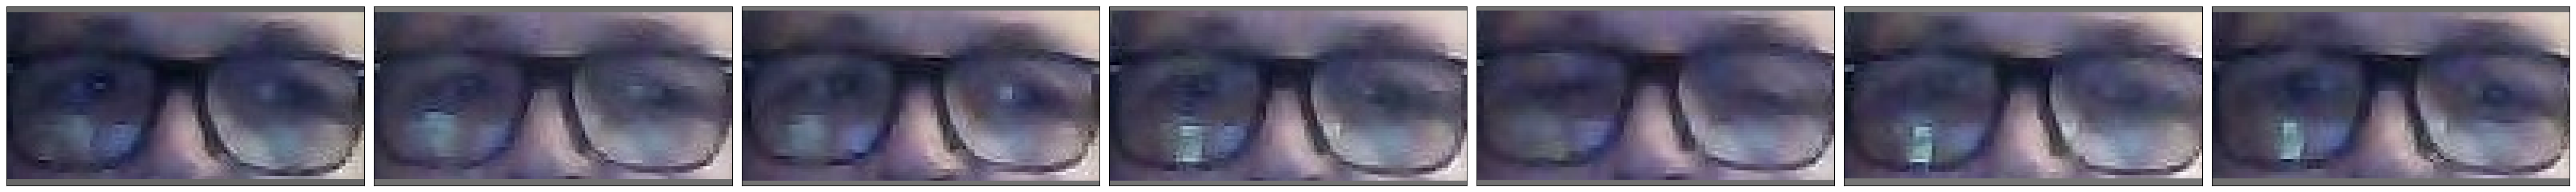

In [70]:
plot([img]+imgs_calibration)
print(f"Label: {label}")

Label: tensor([0.3678, 0.1976], dtype=torch.float64)


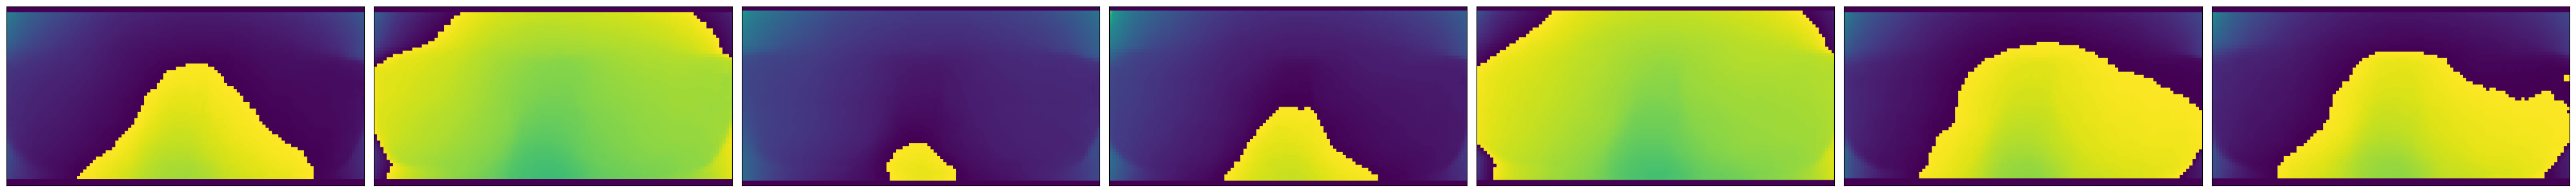

In [71]:
plot([dth]+dths_calibration)
print(f"Label: {label}")

(array([  352.,  1776.,  2560.,  6752., 10512.,  9952., 10160.,  6800.,
         7168.,  6240.,  4768.,  4288., 11504.,  2752.,  1952.,  2192.,
         1952.,  1696.,   992.,   944.,  1008.,   960.,   704.,   752.,
         1376.,   192.,    16.,    16.,     0.,    16.]),
 array([0.        , 0.03298655, 0.0659731 , 0.09895964, 0.13194619,
        0.16493274, 0.19791928, 0.23090583, 0.26389238, 0.29687893,
        0.32986549, 0.36285204, 0.39583856, 0.42882511, 0.46181166,
        0.49479821, 0.52778476, 0.56077129, 0.59375787, 0.62674439,
        0.65973097, 0.69271749, 0.72570407, 0.7586906 , 0.79167712,
        0.8246637 , 0.85765022, 0.8906368 , 0.92362332, 0.9566099 ,
        0.98959643]),
 <BarContainer object of 30 artists>)

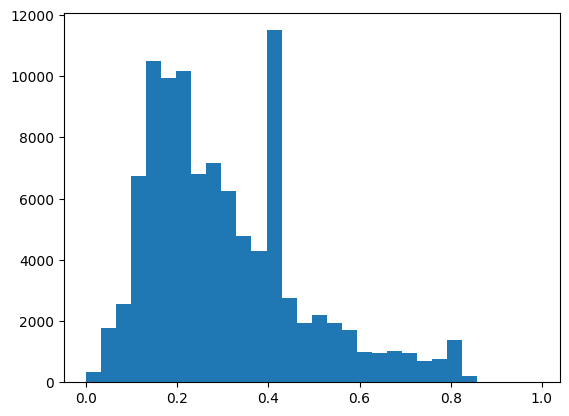

In [72]:
plt.hist(image[0][0].numpy().ravel(), bins=30)

(array([ 7168.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,  2480.,  5360., 13024., 28544., 22080., 12032.,
         4720.,  2624.,  1232.,   624.,   320.,   144.]),
 array([0.        , 0.04721469, 0.09442937, 0.14164406, 0.18885875,
        0.23607343, 0.28328812, 0.33050281, 0.37771749, 0.42493218,
        0.47214687, 0.51936156, 0.56657624, 0.61379093, 0.66100562,
        0.7082203 , 0.75543499, 0.80264968, 0.84986436, 0.89707905,
        0.94429374, 0.99150842, 1.03872311, 1.08593774, 1.13315248,
        1.18036723, 1.22758186, 1.27479649, 1.32201123, 1.36922598,
        1.41644061]),
 <BarContainer object of 30 artists>)

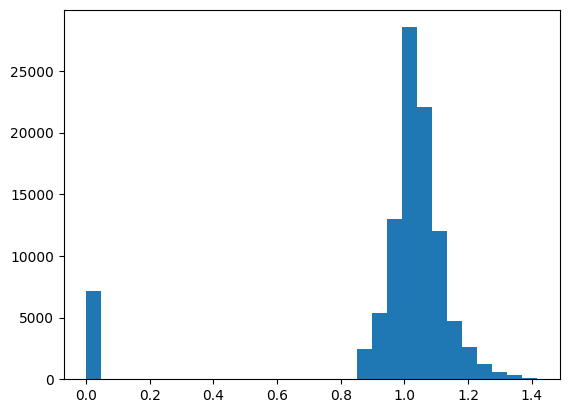

In [73]:
plt.hist(depth[0].squeeze(0).numpy().ravel(), bins=30)

In [74]:
depth.shape

torch.Size([16, 1, 224, 448])

In [75]:
len(calibration_container)

6

In [76]:
imgs_calibration[0].shape

torch.Size([3, 224, 448])

In [77]:
dths_calibration[0].shape

torch.Size([1, 224, 448])

In [78]:
calibration_container[0][1][0].shape

torch.Size([1, 224, 448])

In [79]:
depth.shape

torch.Size([16, 1, 224, 448])

In [80]:
calibration_container[5][2]

tensor([[-1.2576],
        [-1.0193],
        [ 0.1531],
        [ 0.8160],
        [-0.0031],
        [-1.0496],
        [-0.5555],
        [-0.7206],
        [ 1.4127],
        [ 0.1025],
        [ 0.9265],
        [ 0.0786],
        [ 0.5691],
        [ 0.1307],
        [-0.8038],
        [ 0.0647]])

In [81]:
label

tensor([0.3678, 0.1976], dtype=torch.float64)

In [82]:
calibration_container[0][0].shape

torch.Size([16, 3, 224, 448])

In [83]:
focal_length

tensor([[-1.0451, -1.1704],
        [-1.0451, -1.1704],
        [ 0.2371,  0.5675],
        [ 0.6644,  0.5675],
        [ 0.2371,  0.5675],
        [-1.0451, -1.1704],
        [-1.0451, -1.1704],
        [-1.0451, -1.1704],
        [ 1.5192,  0.5675],
        [ 0.2371,  0.5675],
        [ 1.8611,  0.5675],
        [ 0.2371,  0.5675],
        [ 0.2371,  0.5675],
        [ 0.2371,  0.5675],
        [-1.0451, -1.1704],
        [ 0.2371,  0.5675]])

## Neural Network



In [84]:
# https://discuss.pytorch.org/t/changing-the-first-conv-layer-of-a-resnet34/84215

model_main = torchvision.models.resnet50(weights="IMAGENET1K_V2")
model_main.fc = nn.Identity()

In [85]:
model_depth = torchvision.models.resnet18(weights=None)
model_depth.fc = nn.Identity()

model_depth.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
_ = nn.init.kaiming_normal_(model_depth.conv1.weight, mode="fan_out", nonlinearity="relu")

In [86]:
model_depth.conv1

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [87]:
class NeuralNetwork(nn.Module):
    def __init__(self, model_main, model_depth):
        super().__init__()
        self.model_main = model_main
        self.model_depth = model_depth

        input_dim = (
            2048 * 7 + # images
            # 512 * 7 + # depths
            1 * 2 + # original image h, w
            # 6 * 1 + # calibration focal lengths
            6 * 2 + # calibration labels
            7 * 8 # eyes coordinates
        )

        self.head_stack = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Linear(input_dim, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Linear(512, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Linear(512, 2)
        )

        for layer in self.head_stack:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, image, depth, focal_length, eyes_coordinates,
                images_calibration, depths_calibration,
                focal_lengths_calibration, calibration_labels,
                calibration_eyes_coordinates, clamp_eval=True):

        preds = torch.cat(
            [self.model_main(image)] +
            [self.model_main(img_calibration) for img_calibration in images_calibration] +
            # [self.model_depth(depth)] +
            # [self.model_depth(dth_calibration) for dth_calibration in depths_calibration] +
            [focal_length] +
            # [focal_lengths_calibration] +
            [calibration_labels] +
            [eyes_coordinates] +
            [calibration_eyes_coordinates],
            dim=1
        )

        preds = self.head_stack(preds)

        if not self.training and clamp_eval:
            with torch.no_grad():
                preds = torch.clamp(preds, min=0, max=1)

        return preds

In [88]:
report_file_train = '6-points-distance-with-depth-focal-length-eyes-coordinates-layernorm-without-depth-CONTROL-train'
report_file_valid = '6-points-distance-with-depth-focal-length-eyes-coordinates-layernorm-without-depth-CONTROL-valid'

# (image_calibration, depth_calibration, focal_length_calibration, eyes_coordinates_calibration, label_calibration)


# (self, image, depth, focal_length, eyes_coordinates,
#                 images_calibration,
#                 depths_calibration,
#                 focal_lengths_calibration,
#                 calibration_labels,
#                 calibration_eyes_coordinates,
#                 clamp_eval=True)

def train(net, train_dataloader, valid_dataloader, criterion, 
          optimizer, scheduler=None, epochs=10, device='cpu', checkpoint_epochs=10):
    
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')
    
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}/{epochs}")
        
        net.train()  # put network in train mode for Dropout and Batch Normalization
        train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
        train_loss_cm = torch.tensor(0., device=device)
        for image, depth, focal_length, eyes_coordinates, calibration_container, y, screen_size, task_id in train_dataloader:
            image = image.to(device)
            depth = depth.to(device)
            eyes_coordinates = eyes_coordinates.to(device)
            focal_length = focal_length.to(device)
            
            for i in range(6):
                for j in range(5):
                    calibration_container[i][j] = calibration_container[i][j].to(device)
            y = y.to(device)
            screen_size = screen_size.to(device)

            focal_lengths_calibration = torch.cat([calibration_container[i][2] for i in range(len(calibration_container))], 1)
            calibration_labels = torch.cat([calibration_container[i][4] for i in range(len(calibration_container))], 1)
            calibration_eyes_coordinates = torch.cat([calibration_container[i][3] for i in range(len(calibration_container))], 1)
            
            preds = net(
                image, 
                depth,
                focal_length,
                eyes_coordinates, 
                [d[0] for d in calibration_container],
                [d[1] for d in calibration_container],
                focal_lengths_calibration,
                calibration_labels,
                calibration_eyes_coordinates,
            )
            loss = criterion(preds, y).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                loss_cm = criterion(preds*screen_size, y*screen_size).mean()
                train_loss_cm += loss_cm * train_dataloader.batch_size
                
        if valid_dataloader is not None:
            net.eval()
            valid_loss = torch.tensor(0., device=device)
            valid_loss_cm = torch.tensor(0., device=device)
            with torch.no_grad():
                for image, depth, focal_length, eyes_coordinates, calibration_container, y, screen_size, task_id in valid_dataloader:
                    image = image.to(device)
                    depth = depth.to(device)
                    eyes_coordinates = eyes_coordinates.to(device)
                    focal_length = focal_length.to(device)
                    
                    for i in range(6):
                        for j in range(5):
                            calibration_container[i][j] = calibration_container[i][j].to(device)
                    y = y.to(device)
                    screen_size = screen_size.to(device)

                    focal_lengths_calibration = torch.cat([calibration_container[i][2] for i in range(len(calibration_container))], 1)
                    calibration_labels = torch.cat([calibration_container[i][4] for i in range(len(calibration_container))], 1)
                    calibration_eyes_coordinates = torch.cat([calibration_container[i][3] for i in range(len(calibration_container))], 1)
        
                    preds = net(
                        image, 
                        depth,
                        focal_length,
                        eyes_coordinates, 
                        [d[0] for d in calibration_container],
                        [d[1] for d in calibration_container],
                        focal_lengths_calibration,
                        calibration_labels,
                        calibration_eyes_coordinates,
                    )
                    loss = criterion(preds, y).mean()
                    
                    loss_cm = criterion(preds*screen_size, y*screen_size).mean()
                    valid_loss += loss * valid_dataloader.batch_size
                    valid_loss_cm += loss_cm * valid_dataloader.batch_size

        
        if scheduler is not None: 
            scheduler.step()

        with open(report_file_train, 'a') as f:
            for out in [sys.stdout, f]:
                print(f'Train loss, (mean relative distance): {train_loss/len(train_dataloader.dataset):.2f}', file=out)
                print(f'Train loss, (mean distance in cm): {train_loss_cm/len(train_dataloader.dataset):.2f}', file=out)
            
        # wandb.log({"train_loss_relative": train_loss/len(train_dataloader.dataset)})
        # wandb.log({"train_loss_cm": train_loss_cm/len(train_dataloader.dataset)})
        
        if valid_dataloader is not None:
            with open(report_file_valid, 'a') as f:
                for out in [sys.stdout, f]:
                    print(f'Valid loss, (mean relative distance): {valid_loss/len(valid_dataloader.dataset):.2f}', file=out)
                    print(f'Valid loss, (mean distance in cm): {valid_loss_cm/len(valid_dataloader.dataset):.2f}', file=out)
                    
            # wandb.log({"valid_loss_relative": valid_loss/len(valid_dataloader.dataset)})
            # wandb.log({"valid_loss_cm": valid_loss_cm/len(valid_dataloader.dataset)})
        
        if epoch%checkpoint_epochs==0 or epoch==epochs:
            torch.save({
                'epoch': epoch,
                'state_dict': net.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, '/mnt/hdd/ai_n_slo/misc/checkpoint_6_points_depth_focal_length_eyes_coordinates_layernorm-without-depth-CONTROL.pth.tar')
        
        print()
    
    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net

In [89]:
torch.cuda.device_count()

4

In [90]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cuda:3"

CONFIG = {
    "lr": 1e-5,
    "weight_decay": 5e-4
}

epochs = 60

net = NeuralNetwork(model_main, model_depth).to(device)


params_1x = [param for name, param in net.model_main.named_parameters() 
             if "fc" not in name] + [param for name, param in net.model_depth.named_parameters() if "fc" not in name]

params_2x = list(net.head_stack.parameters())

criterion = torch.nn.PairwiseDistance(p=2)

optimizer = torch.optim.Adam([
    {'params':params_1x}, 
    {'params': params_2x, 'lr': CONFIG["lr"]*10}
], **CONFIG)

In [91]:
# summary(net, input_size=[(16,3, 224, 224*2), (16,8)] + [(16,3, 224, 224*2)]*20 + [(16,12)], col_names=["input_size", "output_size", "num_params"])

In [92]:
net = train(net, dataloader_train, dataloader_test,
            criterion, optimizer, None, epochs, device)

Training for 60 epochs on cuda:3
Epoch 1/60


Train loss, (mean relative distance): 0.32
Train loss, (mean distance in cm): 9.43
Valid loss, (mean relative distance): 0.17
Valid loss, (mean distance in cm): 4.71

Epoch 2/60


Train loss, (mean relative distance): 0.17
Train loss, (mean distance in cm): 4.61
Valid loss, (mean relative distance): 0.15
Valid loss, (mean distance in cm): 3.96

Epoch 3/60


Train loss, (mean relative distance): 0.14
Train loss, (mean distance in cm): 3.79
Valid loss, (mean relative distance): 0.13
Valid loss, (mean distance in cm): 3.65

Epoch 4/60


Train loss, (mean relative distance): 0.12
Train loss, (mean distance in cm): 3.38
Valid loss, (mean relative distance): 0.13
Valid loss, (mean distance in cm): 3.33

Epoch 5/60


Train loss, (mean relative distance): 0.11
Train loss, (mean distance in cm): 3.08
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.33

Epoch 6/60


Train loss, (mean relative distance): 0.10
Train loss, (mean distance in cm): 2.86
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.14

Epoch 7/60


Train loss, (mean relative distance): 0.10
Train loss, (mean distance in cm): 2.69
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.26

Epoch 8/60


Train loss, (mean relative distance): 0.09
Train loss, (mean distance in cm): 2.54
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.17

Epoch 9/60


Train loss, (mean relative distance): 0.09
Train loss, (mean distance in cm): 2.42
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.09

Epoch 10/60


Train loss, (mean relative distance): 0.08
Train loss, (mean distance in cm): 2.33
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.08



Epoch 11/60


Train loss, (mean relative distance): 0.08
Train loss, (mean distance in cm): 2.24
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.02

Epoch 12/60


Train loss, (mean relative distance): 0.08
Train loss, (mean distance in cm): 2.17
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.08

Epoch 13/60


Train loss, (mean relative distance): 0.08
Train loss, (mean distance in cm): 2.10
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.19

Epoch 14/60


Train loss, (mean relative distance): 0.07
Train loss, (mean distance in cm): 2.05
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.12

Epoch 15/60


Train loss, (mean relative distance): 0.07
Train loss, (mean distance in cm): 2.00
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.04

Epoch 16/60


Train loss, (mean relative distance): 0.07
Train loss, (mean distance in cm): 1.98
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.11

Epoch 17/60


Train loss, (mean relative distance): 0.07
Train loss, (mean distance in cm): 1.93
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.03

Epoch 18/60


Train loss, (mean relative distance): 0.07
Train loss, (mean distance in cm): 1.90
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.07

Epoch 19/60


Train loss, (mean relative distance): 0.07
Train loss, (mean distance in cm): 1.87
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.10

Epoch 20/60


Train loss, (mean relative distance): 0.07
Train loss, (mean distance in cm): 1.84
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.14



Epoch 21/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.82
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.04

Epoch 22/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.80
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.00

Epoch 23/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.77
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 2.98

Epoch 24/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.75
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.01

Epoch 25/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.73
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.01

Epoch 26/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.72
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 2.97

Epoch 27/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.69
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.04

Epoch 28/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.68
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.06

Epoch 29/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.67
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 2.99

Epoch 30/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.65
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.00



Epoch 31/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.64
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.02

Epoch 32/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.62
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.01

Epoch 33/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.60
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.01

Epoch 34/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.60
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 2.98

Epoch 35/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.58
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.01

Epoch 36/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.57
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.01

Epoch 37/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.56
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.01

Epoch 38/60


Train loss, (mean relative distance): 0.06
Train loss, (mean distance in cm): 1.54
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.00

Epoch 39/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.54
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.00

Epoch 40/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.52
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.01



Epoch 41/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.51
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.01

Epoch 42/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.50
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 2.96

Epoch 43/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.49
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.00

Epoch 44/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.49
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 2.99

Epoch 45/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.47
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 2.98

Epoch 46/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.46
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.00

Epoch 47/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.45
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.01

Epoch 48/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.45
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 2.97

Epoch 49/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.44
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.00

Epoch 50/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.43
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 2.95



Epoch 51/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.42
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 2.95

Epoch 52/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.41
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.03

Epoch 53/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.41
Valid loss, (mean relative distance): 0.12
Valid loss, (mean distance in cm): 3.16

Epoch 54/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.40
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.00

Epoch 55/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.39
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 2.95

Epoch 56/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.38
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 2.96

Epoch 57/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.37
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 2.93

Epoch 58/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.37
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.01

Epoch 59/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.36
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 3.06

Epoch 60/60


Train loss, (mean relative distance): 0.05
Train loss, (mean distance in cm): 1.36
Valid loss, (mean relative distance): 0.11
Valid loss, (mean distance in cm): 2.96



Total training time: 228471.5 seconds


In [93]:
torch.cuda.empty_cache()